# Lab04: Neural Net

(Last update: 16/04/2022)

- Student ID: 19127003
- Student name: Nguyễn Hữu Đạt

---

You will work directly on this notebook; the word `TODO` indicates the part you need to do.  You can discuss ideas with classmates as well as find information from the internet, book, ... but *this lab must be your*.

Before submitting, rerun the notebook (`Kernel` ->` Restart & Run All`). Then create a folder named `ID` (for example, if your ID is 1234567, then name the folder `1234567`). Copy the notebook file (*do not copy the data file*) to this folder, compress and submit it on moodle.

---

**What problem do we want to solve in this lab?**

Given the training data: 
$$\{(\textbf{x}^{(1)}, y^{(1)}), ..., (\textbf{x}^{(N)}, y^{(N)})\}$$
where:

- $\textbf{x}^{(n)} \in \mathbb{R}^{784}$ is an input vector containing pixel values of a $28 \times 28$ grayscale image of some hand-written digit
- $y^{(n)} \in \{0, 1, 2, ..., 9\}$ is the corresponding output indicating which digit

Our task is building a model (in this lab: a Fully-Connected Feed-Forward Neural Net) from this data so that it can take a *new* hand-written digit image (a vector $\in \mathbb{R}^{784}$) as input and predict the output (which digit) *well*.

Before starting, you should review materials about Neural Net (note that different materials can use different notations, but the essence is the same):
- [The course's Neural Net slides](https://drive.google.com/drive/folders/1KDifaACbAuomUiyBsiZfN09gFoKa5iqo) (lect12)
- [3B1B's Neural Net videos](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) (I think it's beautiful and inspirational)
- [My Neural Net slides](https://drive.google.com/file/d/1IH7nXTR-0kVxWyyDlNorlxBAyl0eWECb/view?usp=sharing) (Probably it's the most relevant to this lab)

Are you ready? Let's start!

## Import Python libraries

In [1]:
# You will use Numpy as main lib in this lab
# So, you should use Numpy operations on Numpy arrays, avoid using loops;
# otherwise, the code will run slow
import numpy as np 

# Import other libs
import matplotlib.pyplot as plt
import pickle
import gzip

# We will not use anything else

## Read data and explore a little bit

The specific data we will use in this lab is the famous MNIST dataset of hand-written digit images. [The original MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains 2 sets: training set (60000 images) and test set (10000 images). The MNIST dataset we will use in this lab (the "mnist.pkl.gz" file) contains 3 sets: training set (50000 images), validation set (10000 images), and test set (10000 images); the training set and the validation set here were created by splitting the original training set (60000 images).  

The code below will read data from the "mnist.pkl.gz" file (you shold put the "mnist.pkl.gz" file to the same folder with this notebook file) and store data in 6 Numpy arrays:

- `train_X`, `train_Y`
- `val_X`, `val_Y`
- `test_X`, `test_Y`

In [2]:
def read_mnist(mnist_file):
    '''
    Reads MNIST data.
    
    Parameters
    ----------
    mnist_file : string
        The name of the MNIST file (e.g., 'mnist.pkl.gz').
    
    Returns
    -------
    (train_X, train_Y, val_X, val_Y, test_X, test_Y) : tuple
        train_X : numpy array, shape (N=50000, d=784)
            Input vectors of the training set.
        train_Y : numpy array, shape (N=50000)
            Outputs of the training set.
        val_X : numpy array, shape (N=10000, d=784)
            Input vectors of the validation set.
        val_Y : numpy array, shape (N=10000)
            Outputs of the validation set.
        test_X : numpy array, shape (N=10000, d=784)
            Input vectors of the test set.
        test_Y : numpy array, shape (N=10000)
            Outputs of the test set.
    '''
    
    f = gzip.open(mnist_file, 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    
    train_X, train_Y = train_data
    val_X, val_Y = val_data
    test_X, test_Y = test_data    
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [3]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = read_mnist('mnist.pkl.gz')

print('train_X.shape =', train_X.shape)
print('train_Y.shape =', train_Y.shape)
print('val_X.shape   =', val_X.shape)
print('val_Y.shape   =', val_Y.shape)
print('test_X.shape  =', test_X.shape)
print('test_Y.shape  =', test_Y.shape)

print('\ntrain_X: min = %.3f, max = %.3f' %(train_X.min(), train_X.max()))
print('train_Y: min = %d, max = %d' %(train_Y.min(), train_Y.max()))

train_X.shape = (50000, 784)
train_Y.shape = (50000,)
val_X.shape   = (10000, 784)
val_Y.shape   = (10000,)
test_X.shape  = (10000, 784)
test_Y.shape  = (10000,)

train_X: min = 0.000, max = 0.996
train_Y: min = 0, max = 9


## Build a good Neural Net from data

### Implement functions to train a Neural Net

In this lab, we will use a simple form of Neural Net: Fully-Connected Feed-Forward Neural Net. We will use sigmoid function as activation function in hidden layers *as well as in output layer* (using sigmoid instead of softmax in output layer will make our life easier). We will have $K$ neurons in output layer with $K$ is the number of classes (in our case, $K = 10$); the output of each neuron will indicate the probability a given input vector belonging to the corresponding class (note that sum of all these probabilities will not equal 1 as softmax). We can choose the class with highest probability as the predicted class for a given input vector.


In our first step, we will implement `compute_nnet_outputs` function *(3 points)*. We will use this function not only after training (to compute outputs of our trained Neural Net with new input vectors) but also during the training process (which we will tackle in our next step).

In [4]:
def sigmoid(S):
    '''
    Computes sigmoid function for each element of array S.
    You can use this function in `compute_nnet_outputs` function.
    '''
    return 1 / (1 + np.exp(-S))

def compute_nnet_outputs(Ws, X, need_all_layer_outputs):
    '''
    Computes the outputs of Neural Net by forward propagating X through the net.
    
    Parameters
    ----------
    Ws : list of numpy arrays
        Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer, 
        it doesn't have W); W of layer l will have the shape of 
        (d^(l-1)+1, d^(l)), where  d^(l-1) is the number of neurons 
        (not count the +1 neuron) of layer l-1 and  d^(l) is the number of 
        neurons (not count the +1 neuron) of layer l.
    X : numpy array, shape (N, d+1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    need_all_layer_outputs : bool
        If this var is true, we'll return a list of layer's-outputs (we'll 
        need this list when training); otherwise, we'll return the final 
        layer's output.
    
    Returns
    -------
    If `need_all_layer_outputs` is false, return
        A : numpy array, shape (N, K=10)
            The maxtrix of output vectors of final layer; each row is an 
            output vector (containing each class's probability given the 
            corresponding input vector).
    Else, return
        As : list of numpy arrays
            As[l] is the matrix of output vectors of layer l (l=0 will 
            correspond to input layer); each row is an output vector 
            (corresponding to an input vector); if layer l is not the final 
            layer, the first column of this matrix is all ones.
    '''    
    
    # TODO
    # NOTE: to make the code run fast, you should use Numpy operations on
    # Numpy arrays; your code should have only one loop to loop through layers
    
    As = list()
    As.append(X)
    for i in range(1, len(Ws) + 1):
        out = sigmoid(As[i-1]@Ws[i-1])
        if i < len(Ws):
            out = np.concatenate((np.ones((out.shape[0], 1)), out), axis=1)
        As.append(out)
    
    if not need_all_layer_outputs:
        return As[-1]
    else: return As
        
    

In [5]:
# CHECK THE CORRECTNESS OF YOUR COMPUTE_NNET_OUTPUTS FUNCTION

# A small X with 4 rows corresponding to 4 input vectors
X = np.array([[1.0, 0.9, 0.9], 
              [1.0, 0.5, 0.4], 
              [1.0, 0.4, 0.5],
              [1.0, 0.1, 0.7]])
# A small neural net: 
# 2 input neurons - 3 hidden neurons - 2 hidden neurons - 1 output neurons
# (not counting +1 neurons)
Ws = [np.array([[-0.3 ,  0.2 ,  0.5 ],
                [-0.1 , -0.2 , -0.35],
                [ 0.45, -0.7 , -0.7 ]]),
      np.array([[ 0.3 , -0.05],
                [ 0.6 ,  0.3 ],
                [-0.8 , -0.3 ],
                [ 0.4 , -0.45]]),
      np.array([[-0.3 ],
                [ 0.5 ],
                [-0.45]])]

# Check your compute_nnet_outputs function!
A = compute_nnet_outputs(Ws, X, False)
assert np.array_equal(np.round(A, 5),
                      np.array([[0.45109],
                                [0.45199],
                                [0.4521],
                                [0.45247]]))
As = compute_nnet_outputs(Ws, X, True)
assert len(As) == 4
assert np.array_equal(np.round(As[0], 5),
                      np.array([[1. , 0.9, 0.9],
                                [1. , 0.5, 0.4],
                                [1. , 0.4, 0.5],
                                [1. , 0.1, 0.7]]))
assert np.array_equal(np.round(As[1], 5),
                      np.array([[1.     , 0.50375, 0.35206, 0.39055],
                                [1.     , 0.4576 , 0.45512, 0.51125],
                                [1.     , 0.47128, 0.44275, 0.5025 ],
                                [1.     , 0.50125, 0.42311, 0.49375]]))
assert np.array_equal(np.round(As[2], 5),
                      np.array([[1.     , 0.617  , 0.45506],
                                [1.     , 0.60228, 0.43062],
                                [1.     , 0.60577, 0.4335 ],
                                [1.     , 0.61296, 0.43813]]))
assert np.array_equal(np.round(As[3], 5),
                      np.array([[0.45109],
                                [0.45199],
                                [0.4521 ],
                                [0.45247]]))

Now, we will implement our main function: `train_nnet` *(4 points)*. Basically, in this function, we will find values of our Neural Net weights by minimizing mean cross-entropy error on the training set  $\{(\textbf{x}^{(1)}, y^{(1)}), ..., (\textbf{x}^{(N)}, y^{(N)})\}$:
$$E(w\text{'s of our Net}) = \frac{1}{N} \sum_{n=1}^Ne(h(\textbf{x}^{(n)}), \textbf{y}^{(n)}))$$
where:
- $h(\textbf{x}^{(n)}) \in \mathbb{R}^{K}$ is the output vector (containing probabilities) of our Neural Net corresponding to the input vector $\textbf{x}^{(n)}$
- $\textbf{y}^{(n)} \in \mathbb{R}^{K}$ is the one-hot representation of $y^{(n)}$ (can you see the difference between  $\textbf{y}^{(n)}$ and $y^{(n)}$?) \
For example, in our case $K=10$ (10 digits):
    - If $y^{(n)}=0$ (digit 0) then $\textbf{y}^{(n)}=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]^T$
    - If $y^{(n)}=1$ (digit 1) then $\textbf{y}^{(n)}=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]^T$
- $e(h(\textbf{x}^{(n)}), \textbf{y}^{(n)}))$ is the cross-entropy error on a single training pair $(\textbf{x}^{(n)}, y^{(n)})$:
$$e(h(\textbf{x}^{(n)}), \textbf{y}^{(n)})) = \sum_{k=1}^K - y^{(n)}_k \ln h(\textbf{x}^{(n)})_k - (1 - y^{(n)}_k)\ln (1 - h(\textbf{x}^{(n)})_k)$$

If we use GD (Gradient Descent) to minimize $E(w\text{'s of our Net})$, we will need to compute partial derivatives of $E$ with respect to $w\text{'s}$. To compute these partial derivatives, we will compute partial derivatives of $e$ (cross-entropy error on a single training pair $\mathbf{x}$ and $y$) with respect to $w\text{'s}$, and then take average over all training pairs. But it will slow when our training set is big. SGD (Stochastic Gradient Descent) approximates the average of partial derivatives over all training pairs by the average of partial derivatives over a mini-batch (a subset of training pairs); so, it's faster than GD. Another name of SGD: "túy quyền" ;-). In `train_nnet` function below, we will use SGD.

Let's focus on how to compute the partial derivative of $e$ (cross-entropy error on a single training pair $\mathbf{x}$ and $y$) with respect to a weight $w$ between a neuron i in layer l-1 and a neuron j in layer l. After applying chain rule (see [my Neural Net slides](https://drive.google.com/file/d/1IH7nXTR-0kVxWyyDlNorlxBAyl0eWECb/view) for details), we have the formula: 
$$\text{this partial derivative} = \text{output of neuron i in layer l-1} \times \text{delta of neuron j in layer l}$$
with delta of a neuron is the partial derivative of $e$ with respect to the weighted sum (value before applying activation function) of that neuron.

I have implemented most of `train_nnet` function for you. Your job is to write 3 lines of code corresponding to 3/4 tasks below:

**Task 1. Compute delta's of the last layer (on a mini-batch)**

For example, let's consider $K=3$ (3 classes) and a mini-batch with size of 2 (2 training pairs), if:

        A = np.array([[0.8, 0.7, 0.6],
                      [0.5, 0.6, 0.5]]) # Output vectors of last layer 
                                          on this mini-batch
        mb_Y = np.array([[0, 1, 0],
                         [1, 0, 0]]) # Correct one-hot output vectors 
                                       of this mini-batch
then delta's of the last layer on this mini-batch will be:

        delta = np.array([[ 0.8, -0.3,  0.6],
                          [-0.5,  0.6,  0.5]])
You should do the math to figure out the exact formula to compute delta's of the last layer. In case it's difficult for you, try your luck and guess the formula from the result above ;-). Again, when implementing this task, you should use Numpy operations on Numpy arrays; this task should be done with just one line of code.

**Task 2. Compute gradient - a collection of partial derivatives - of the last layer from delta's of the last layer and outputs of the previous layer (on a mini-batch)**

For example, let's consider $K=3$ (3 classes; it's also the number of neurons in the last layer L), the previous layer (layer L-1) with 4 neurons, and a mini-batch with size of 2 (2 training pairs), if:

        delta = np.array([[ 0.8, -0.3,  0.6],
                          [-0.5,  0.6,  0.5]]) # Delta vectors of last layer 
                                                 on this mini-batch
        A = np.array([[1.0, 0.5, 0.1, 0.3, 0.2],
                      [1.0, 0.9, 0.8, 0.7, 0.1]]) # Output vectors of the previous layer 
                                                    on this mini-batch
then the gradient of the last layer will be (it has the same shape with `W` array of the last layer):

        grad = np.array([[ 0.15 ,  0.15 ,  0.55 ],
                         [-0.025,  0.195,  0.375],
                         [-0.16 ,  0.225,  0.23 ],
                         [-0.055,  0.165,  0.265],
                         [ 0.055,  0.   ,  0.085]]) # For clarity, I use 
                                                      np.round(..., 3) to show this
How is `grad` computed from `delta` and `A`? Hint: I have mentioned above how to compute the partial derivative of cross-entropy error on a single training pair with respect to a weight; for a mini-batch, just compute it for each training pair and then take average.

Again, when implementing this task, you should use Numpy operations on Numpy arrays; this task should be done with just one line of code.

**Task 3. Compute delta's of layer l from delta's of layer l+1 (on a mini-batch)**

(Note that we will not compute delta's of +1 neurons)

This is the most difficult task, but I have done it for you :-). 


**Task 4. Compute gradient of layer l from delta of layer l and outputs of layer l-1 (on a mini-batch)**

It's similar to task 2.

In [6]:
def train_nnet(X, Y, val_X, val_Y, 
               hid_layer_sizes, 
               mb_size, learning_rate, max_epoch):
    '''
    Trains Neural Net on the dataset (X, Y); also prints out mean binary error 
    (the percentage of misclassified data points) on training set and 
    validation set during training
    Cost function: mean cross-entropy error
    Optimization algorithm: SGD
    
    Parameters
    ----------
    X : numpy array, shape (N, d + 1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    Y : numpy array, shape (N,) 
        The vector of outputs.
    val_X, val_Y : validation data, similar to X and Y
    hid_layer_sizes : list
        The list of hidden layer sizes; e.g., hid_layer_sizes = [20, 10] means
        the Net has 2 hidden layers, the 1st one has 20 neurons, and the 2nd 
        one has 10 neurons (not count the +1 neurons).
    mb_size : int
        Minibatch size of SGD.
    learning_rate : float
        Learning rate of SGD.
    max_epoch : int
        After this number of epochs, we'll terminate SGD.

    Returns
    -------
    (Ws, costs, errs) : tuple
        Ws : list of numpy arrays
            Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer, 
            it doesn't have W); W of layer l will have the shape of 
            (d^(l-1)+1, d^(l)), where d^(l-1) is the number of neurons 
            (not count the +1 neuron) of layer l-1 and d^(l) is the number of 
            neurons (not count the +1 neuron) of layer l.
        costs : list, len = max_epoch
            The list of costs after each epoch.
        errs : list, len = max_epoch
            The list of mean binary errors (on the training set) after each epoch.
    '''
    
    # Prepare for training
    K = len(np.unique(Y)) # Num classes
    layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [K]
    np.random.seed(0) # This will fix the randomization; 
                      # so, you and me will have the same results
    Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) 
          / np.sqrt(layer_sizes[i] + 1) 
          for i in range(len(layer_sizes) - 1)] # Secret formula to init Ws ;-)
    one_hot_Y = np.zeros((len(Y), K))
    one_hot_Y[np.arange(len(Y)), Y] = 1
    errs = [] # To save mean binary errors on training set during training
    val_errs = [] # To save mean binary errors on validation set during training
    N = len(X) # Num training examples
    rnd_idxs = np.arange(N) # Random indexes    
    
    # Train
    for epoch in range(max_epoch):
        np.random.shuffle(rnd_idxs)
        for start_idx in range(0, N, mb_size):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            
            # Back-prop; on the way, compute each layer's gradient and update its W
            # TODO: delta = ... (task 1)
            delta = As[-1] - mb_Y
            
            # TODO: grad = ... (task 2)
            grad = (1/As[-2].shape[0])*As[-2].T@delta
            
            Ws[-1] -= learning_rate * grad
            for i in range(2, len(Ws) + 1):
                delta = delta.dot(Ws[-i + 1].T[:, 1:]) * As[-i][:, 1:] * (1 - As[-i][:, 1:])
                # TODO: grad = ... (task 4)
                grad = (1/As[-i-1].shape[0])*As[-i-1].T@delta
                Ws[-i] -= learning_rate * grad
        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)
        err = np.mean(np.argmax(A, axis=1) != Y) * 100
        errs.append(err)
        val_A = compute_nnet_outputs(Ws, val_X, False)
        val_err = np.mean(np.argmax(val_A, axis=1) != val_Y) * 100
        val_errs.append(val_err)
        print('Epoch %d, train err %.3f%%, val err %.3f%%' %(epoch, err, val_err))
            
    return Ws, errs, val_errs

In [7]:
# CHECK THE CORRECTNESS YOUR TRAIN_NNET FUCTION
Ws, train_errs, val_errs = train_nnet(train_X, train_Y, val_X, val_Y,
                                      hid_layer_sizes=[20], 
                                      mb_size=32, learning_rate=0.1, max_epoch=3)
assert np.array_equal(np.round(train_errs, 3),
                      np.array([10.982, 9.044, 7.962]))
assert np.array_equal(np.round(val_errs, 3),
                      np.array([9.82, 8.23, 7.49]))

Epoch 0, train err 10.982%, val err 9.820%
Epoch 1, train err 9.044%, val err 8.230%
Epoch 2, train err 7.962%, val err 7.490%


### Use implemented functions to train different Neural Nets and choose the best

In [8]:
# Shallow Neural Net
Ws_50, train_errs_50, val_errs_50 = \
    train_nnet(train_X, train_Y, val_X, val_Y, 
               hid_layer_sizes=[50], 
               mb_size=32, learning_rate=0.1, max_epoch=30)

Epoch 0, train err 9.998%, val err 8.930%
Epoch 1, train err 8.592%, val err 7.930%
Epoch 2, train err 7.186%, val err 6.810%
Epoch 3, train err 6.372%, val err 5.830%
Epoch 4, train err 5.750%, val err 5.350%
Epoch 5, train err 5.404%, val err 5.060%
Epoch 6, train err 4.944%, val err 4.810%
Epoch 7, train err 4.670%, val err 4.560%
Epoch 8, train err 4.386%, val err 4.370%
Epoch 9, train err 4.110%, val err 4.210%
Epoch 10, train err 3.882%, val err 4.000%
Epoch 11, train err 3.678%, val err 3.970%
Epoch 12, train err 3.490%, val err 3.840%
Epoch 13, train err 3.310%, val err 3.720%
Epoch 14, train err 3.210%, val err 3.620%
Epoch 15, train err 3.042%, val err 3.590%
Epoch 16, train err 2.952%, val err 3.510%
Epoch 17, train err 2.818%, val err 3.440%
Epoch 18, train err 2.786%, val err 3.450%
Epoch 19, train err 2.646%, val err 3.400%
Epoch 20, train err 2.596%, val err 3.320%
Epoch 21, train err 2.478%, val err 3.270%
Epoch 22, train err 2.370%, val err 3.180%
Epoch 23, train err 2

In [9]:
# Deeper Neural Net
Ws_50_50, train_errs_50_50, val_errs_50_50 = \
    train_nnet(train_X, train_Y, val_X, val_Y, 
               hid_layer_sizes=[50, 50], 
               mb_size=32, learning_rate=0.1, max_epoch=30)

Epoch 0, train err 15.316%, val err 14.110%
Epoch 1, train err 9.948%, val err 9.000%
Epoch 2, train err 7.972%, val err 7.390%
Epoch 3, train err 6.688%, val err 6.440%
Epoch 4, train err 5.838%, val err 5.520%
Epoch 5, train err 5.768%, val err 5.270%
Epoch 6, train err 4.638%, val err 4.490%
Epoch 7, train err 4.384%, val err 4.320%
Epoch 8, train err 3.888%, val err 4.060%
Epoch 9, train err 3.592%, val err 3.840%
Epoch 10, train err 3.350%, val err 3.760%
Epoch 11, train err 3.024%, val err 3.490%
Epoch 12, train err 2.808%, val err 3.310%
Epoch 13, train err 2.626%, val err 3.240%
Epoch 14, train err 2.482%, val err 3.300%
Epoch 15, train err 2.388%, val err 3.220%
Epoch 16, train err 2.292%, val err 3.100%
Epoch 17, train err 2.046%, val err 3.000%
Epoch 18, train err 2.038%, val err 3.090%
Epoch 19, train err 1.912%, val err 2.980%
Epoch 20, train err 1.786%, val err 2.750%
Epoch 21, train err 1.732%, val err 2.870%
Epoch 22, train err 1.722%, val err 3.080%
Epoch 23, train err

In [10]:
# Even more deeper Neural Net!
Ws_50_50_50, train_errs_50_50_50, val_errs_50_50_50 = \
    train_nnet(train_X, train_Y, val_X, val_Y, 
               hid_layer_sizes=[50, 50, 50], 
               mb_size=32, learning_rate=0.1, max_epoch=30)

Epoch 0, train err 57.134%, val err 56.460%
Epoch 1, train err 18.336%, val err 16.730%
Epoch 2, train err 10.690%, val err 9.870%
Epoch 3, train err 8.028%, val err 7.620%
Epoch 4, train err 6.176%, val err 5.960%
Epoch 5, train err 5.308%, val err 5.230%
Epoch 6, train err 4.412%, val err 4.630%
Epoch 7, train err 3.892%, val err 4.280%
Epoch 8, train err 3.588%, val err 3.880%
Epoch 9, train err 3.230%, val err 3.860%
Epoch 10, train err 2.974%, val err 3.810%
Epoch 11, train err 2.686%, val err 3.600%
Epoch 12, train err 2.740%, val err 3.890%
Epoch 13, train err 2.272%, val err 3.400%
Epoch 14, train err 2.552%, val err 3.570%
Epoch 15, train err 2.530%, val err 3.530%
Epoch 16, train err 1.922%, val err 3.420%
Epoch 17, train err 1.904%, val err 3.460%
Epoch 18, train err 1.762%, val err 3.220%
Epoch 19, train err 1.366%, val err 3.040%
Epoch 20, train err 1.264%, val err 3.090%
Epoch 21, train err 1.394%, val err 3.360%
Epoch 22, train err 1.284%, val err 3.190%
Epoch 23, train 

Visualize results:

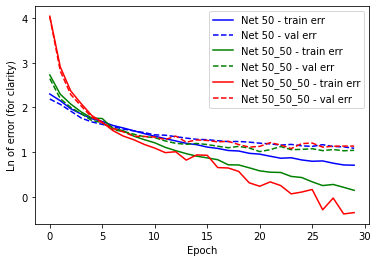

In [11]:
plt.plot(np.log(train_errs_50), color='blue', 
         label='Net 50 - train err')
plt.plot(np.log(val_errs_50), color='blue', linestyle='--', 
         label='Net 50 - val err')
plt.plot(np.log(train_errs_50_50), color='green',
         label='Net 50_50 - train err')
plt.plot(np.log(val_errs_50_50), color='green', linestyle='--',
         label='Net 50_50 - val err')
plt.plot(np.log(train_errs_50_50_50), color='red',
         label='Net 50_50_50 - train err')
plt.plot(np.log(val_errs_50_50_50), color='red', linestyle='--',
         label='Net 50_50_50 - val err')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Ln of error (for clarity)');

TODO: comment on the graph above (Why is it like this? In case you don't know why, just simply say so) *(2 points)*.

- Độ lỗi của cả ba mô hình đều giảm dần theo số epoch, bên cạnh đó mô hình nào có nhiều layer hơn (deeper) thì đạt được độ lỗi tốt hơn sau khi training. Điều này có thể lí giải rằng, việc sử dụng nhiều layer hơn có thể đem lại kết quả tốt hơn trong quá trình training nhưng tốc độ chắc chắn sẽ bị hạn chế hơn, bên cạnh đó không tránh khỏi khả năng overfitting.
- Mặc dù mô hình với 3 hidden layers có độ lỗi tốt nhất trên tập training tuy nhiên khi thực hiện kiểm tra trên tập validation thì mô hình 2 hidden layers đạt được độ lỗi tốt hơn và là tốt nhất, tuy nhiên khác biệt không quá lớn khi so với 2 mô hình còn lại.

We will choose the Neural Net model having smallest mean binary error on the validation set as our best Neural Net model.

## How good our Neural Net actually is

Let's compute mean binary error ($\in [0, 100]$) of our best Neural Net model on the test set and store result in `test_err` variable *(1 points)*. 

In [12]:
# TODO
A = compute_nnet_outputs(Ws_50_50, test_X, False)
test_err = np.mean(np.argmax(A, axis=1) != test_Y) * 100

In [13]:
# CHECK CORRECTNESS
assert np.round(test_err, 3) == 2.860